<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<p><p><p><p>
<b>Quick demo of the Image Cutout Service</b> <br>
Contact author: <i>Leanne Guy</i> <br>
Last verified to run: <i>2023-06-16</i> <br>
LSST Science Piplines version: Weekly <i>2023_21</i> <br>
Container Size: <i>medium</i> <br>
Targeted learning level: <i>intermediate</i> <br>

In [1]:
# Import general python packages
import numpy as np
import re
import pandas
from pandas.testing import assert_frame_equal
import uuid
import requests
import warnings

# Import the Rubin TAP service utilities
from lsst.rsp import get_tap_service, retrieve_query

# Science Pipelines imports
from lsst.daf.butler import Butler, DatasetType, CollectionType
import lsst.geom as geom
import lsst.resources
import lsst.geom as geom
import lsst.afw.image as afwImage
from lsst.afw.image import Image, ImageF, Exposure, ExposureF
import lsst.afw.display as afwDisplay

# Plotting with MPL
import matplotlib.pyplot as plt

# Import the Rubin TAP service utilities
from lsst.rsp import get_tap_service
from lsst.rsp import get_tap_service, retrieve_query
from lsst.rsp.utils import get_access_token

# PyVO packages
import pyvo
from pyvo.dal.adhoc import DatalinkResults, SodaQuery

# Astropy
from astropy import units as u
from astropy.units import UnitsWarning
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.time import Time
from astropy.utils.data import download_file
from astropy.visualization import  ZScaleInterval, AsinhStretch
from astropy.wcs import WCS       
from astropy.visualization import simple_norm, imshow_norm
from astropy.visualization import ImageNormalize,  ZScaleInterval
from astropy.visualization.stretch import SinhStretch, LinearStretch, SqrtStretch

import matplotlib.pyplot as plt      # imports matplotlib.pyplot as plt

# Holoviz for interactive visualization
import bokeh
from bokeh.io import output_file, output_notebook, show
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource, CDSView, GroupFilter, HoverTool
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
import holoviews as hv
from holoviews import streams, opts
from holoviews.operation.datashader import rasterize

In [2]:
afwDisplay.setDefaultBackend('matplotlib')

In [3]:
def plotImage(exposure: ExposureF, img_opt: dict = None):
    """Plot and image using matplotlib
   
   Parameters
    ----------
    image : `Exposure`
        the image to plot
        
    opts : ``
   
   Returns
    -------
    title : `str` (only if result is not `None`)
        Plot title from string
    """
    
    fig, ax = plt.subplots()
    display = afwDisplay.Display(frame=fig)
    display.scale('asinh', 'zscale')
    display.mtv(exposure.image)
    plt.show()


##butler = Butler('dp02', collections='2.2i/runs/DP0.2')
registry = butler.registry Get an image via the butler

In [4]:
# Instantiate a Butler
butler = Butler('dp02', collections='2.2i/runs/DP0.2')
registry = butler.registry

In [5]:
# Define a point on the sky and find which patch/tract it is in
dataId_coadd = dict(tract=4431, patch=17, band="i", skymap="DC2") 
datasetRef_coadd = registry.findDataset('deepCoadd_calexp', dataId_coadd)
coadd_calexp = butler.get(datasetRef_coadd)
assert type(coadd_calexp) == lsst.afw.image.ExposureF
print(coadd_calexp.getFilter())

FilterLabel(band="i")


In [6]:
# Get the UUID of the coadd
datasetRef_coadd.id

UUID('20d28216-534a-4102-b8a7-1c7f32a9b78c')

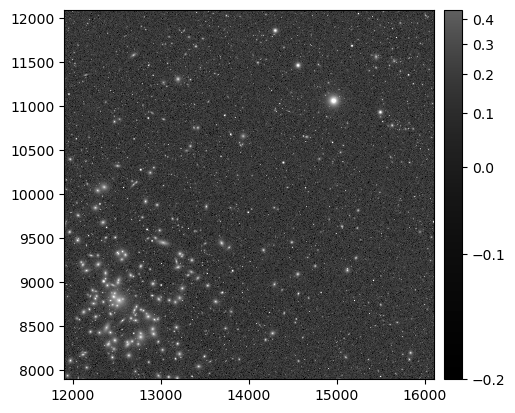

In [7]:
plotImage(coadd_calexp)

In [8]:
# Let's get the coordinates of the galaxy cluster
x,y = (12500, 8500)
radec = coadd_calexp.getWcs().pixelToSky(x,y)
print(radec.getRa().asDegrees(), radec.getDec().asDegrees())

NameError: name 'radec' is not defined

In [ ]:
# Define a circle around the galaxy cluster in the bottom left
point = lsst.geom.SpherePoint(
    radec.getRa().asDegrees() * lsst.geom.degrees, 
    radec.getDec().asDegrees() * lsst.geom.degrees)
radius = 100 * lsst.geom.arcseconds

## Use the cutout service to get a cutout of a specified region

In [ ]:
# Get the tap service instance 
service = get_tap_service("tap")

In [ ]:
# Before proceeding we need to extract the session authentiction for reuse. Explain more about this
auth_session = service._session

In [ ]:
# Query the ObsCore table to find the image that contains the point defined above
query = """
SELECT access_format, access_url, dataproduct_subtype, lsst_patch, lsst_tract, lsst_band, s_ra, s_dec
FROM ivoa.ObsCore 
WHERE dataproduct_type = 'image'
AND obs_collection = 'LSST.DP02' 
AND dataproduct_subtype = 'lsst.deepCoadd_calexp'
AND lsst_tract = 4431
AND lsst_patch = 17
AND lsst_band = 'i'
"""

In [ ]:
results = service.search(query)
results.to_table().show_in_notebook()

In [ ]:
# Extract the access URL from the result in the first row
result = results[0]
dataLinkUrl = result.getdataurl()
f"Datalink link service url: {dataLinkUrl}"

In [ ]:
# Using the results 'r' above, we can see the centre of the coordinates
print("ra:", result.get("s_ra"), "dec:", result.get("s_dec"))

In [ ]:
# Call PyVo's DatalinkResults with the DataLink URL for the image we want to retrieve. 
# This returns a list matching records, each record containoing a set of metadata describing the record.
dl_results = DatalinkResults.from_result_url(dataLinkUrl,session=auth_session)

In [ ]:
dl_results.to_table().show_in_notebook()

In [ ]:
sq = SodaQuery.from_resource(dl_results, dl_results.get_adhocservice_by_id("cutout-sync"), 
                             session=auth_session)

In [ ]:
sq.circle = (point.getRa().asDegrees(), point.getDec().asDegrees(), radius.asDegrees())

In [ ]:
print(sq)

In [ ]:
sodaPoly = os.path.join(os.getenv('HOME'), 'DATA/soda-test.fits')
with open(sodaPoly, 'bw') as f:
    f.write(sq.execute_stream().read())

In [ ]:
# Display the cutout
i = ImageF(sodaPoly)     #read FITS file into afw image object
afw_display = lsst.afw.display.Display()      #get an alias to the lsst.afw.display.Display() method
afw_display.scale('asinh', 'zscale')    #set the image stretch algorithm and range
afw_display.mtv(i) 